<a href="https://colab.research.google.com/github/mermovich/analytics/blob/main/a_b_testing_revenue_site_users.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 📓 Desciption

The site launched an A/B test in order to increase income. The excel file contains raw data on the results of the experiment (user_id), sample type (variant_name) and income brought by the user (revenue).
The task is to analyze the results of the experiment and write your recommendations.

https://www.kaggle.com/datasets/sergylog/ab-test-data

<br>

### 🖊 We will analyse the following
- Data Preprocessing
- Exploratory Data Analysis
- Check Normality: Shapiro Test.
- Check Variences: Levene Test.
- AB tests: Mann Whitney U Test.
- Make inferences

## ⚙ Libraries and Settings 

In [35]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats
from scipy import stats as st
import pylab  
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import statsmodels.stats.api as sms

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.3f}'.format)
pd.set_option('display.max_colwidth', None) 

## 📂 Data download and preprocessing 

In [36]:
! gdown --id 1MNUtK-3JI9aFNSU3a5SVDJgoRPX27-bA

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MNUtK-3JI9aFNSU3a5SVDJgoRPX27-bA
To: /content/AB_Test_Results.csv
100% 169k/169k [00:00<00:00, 76.4MB/s]


In [37]:
df = pd.read_csv('/content/AB_Test_Results.csv')
df.columns = df.columns.str.lower()
df.head()

,user_id,variant_name,revenue
0,737,variant,0.000
1,2423,control,0.000
2,9411,control,0.000
3,7311,control,0.000
4,6174,variant,0.000


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  int64  
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [39]:
df.describe([0.25, 0.50, 0.75, 0.95, 0.99, 1])

,user_id,revenue
count,"10,000.000","10,000.000"
mean,"4,981.080",0.099
std,"2,890.590",2.319
min,2.000,0.000
25%,"2,468.750",0.000
50%,"4,962.000",0.000
75%,"7,511.500",0.000
95%,"9,488.100",0.000
99%,"9,914.010",1.661
100%,"10,000.000",196.010


In [40]:
df.isnull().sum()

user_id         0
variant_name    0
revenue         0
dtype: int64

In [41]:
df.duplicated().sum()

2067

In [42]:
df['user_id'].nunique()

6324

In [43]:
duplicates = df.groupby('user_id')['variant_name'].nunique().reset_index()
duplicates['variant_name'].value_counts(normalize=True)

1                  0.756
2                  0.244
Name: variant_name, dtype: float64

- Around 25% users are in two groups. Delete them. 

In [44]:
df = df[df['user_id'].isin(duplicates[duplicates['variant_name'] == 1]['user_id'])] 
df.describe([0.25, 0.50, 0.75, 0.95, 0.99])

,user_id,revenue
count,"6,070.000","6,070.000"
mean,"4,983.664",0.107
std,"2,897.990",2.674
min,2.000,0.000
25%,"2,472.250",0.000
50%,"4,950.000",0.000
75%,"7,501.000",0.000
95%,"9,521.550",0.000
99%,"9,920.310",2.160
max,"9,998.000",196.010


- More then 95% of all users - not paying users.

<Axes: xlabel='revenue', ylabel='variant_name'>

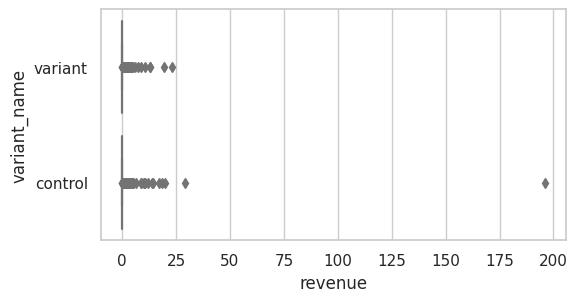

In [45]:
sns.boxplot(data = df, x = 'revenue', y = 'variant_name')

- There is one outlier here. Delete it.

In [46]:
df = df.query('revenue < 175')

- The data is ready, let's do EDA!

## 📊  Exploratory Data Analysis


#### All users

In [47]:
def perc_95(column):
    return np.percentile(column, 95)
def perc_99(column):
    return np.percentile(column, 99)  
df.groupby('variant_name').agg({'user_id':'nunique', 
                                'revenue':['count', 'sum', 'mean', 'median', perc_95, perc_99, 'sum']})

user_id revenue                                                                                                                              
             nunique   count                  sum                 mean               median              perc_95              perc_99                  sum
variant_name                                                                                                                                              
control         2389    3025              274.550                0.091                0.000                0.000                2.311              274.550
variant         2393    3044              179.320                0.059                0.000                0.000                1.279              179.320

<Axes: xlabel='revenue', ylabel='variant_name'>

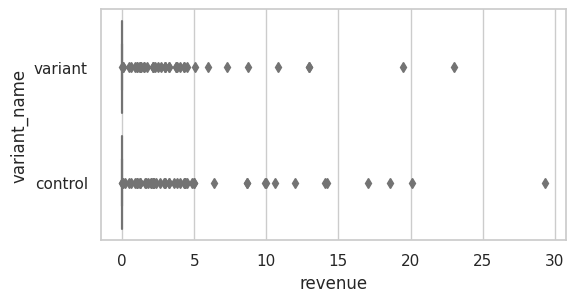

In [48]:
sns.boxplot(data = df, x = 'revenue', y = 'variant_name')

<Axes: xlabel='revenue', ylabel='Count'>

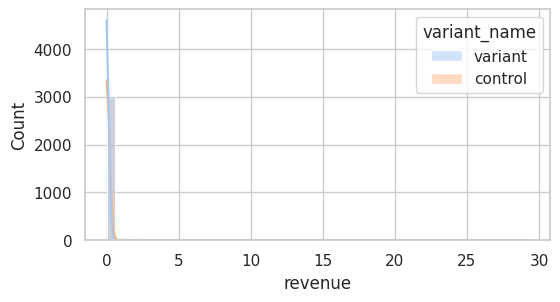

In [64]:
sns.set(rc={'figure.figsize':(6,3)}, style="whitegrid", palette="pastel")
sns.histplot(data = df, x = 'revenue', hue='variant_name', kde=True, bins=50) 

#### Paying Users

In [50]:
df_revenue = df.query('revenue > 0')
df_revenue.groupby('variant_name').agg({'user_id':'nunique', 
                                        'revenue':['count', 'sum', 'min', 'mean', 'median', perc_95, perc_99, 'sum']})

user_id revenue                                                                                                                                                   
             nunique   count                  sum                  min                 mean               median              perc_95              perc_99                  sum
variant_name                                                                                                                                                                   
control           53      53              274.550                0.020                5.180                2.990               17.654               24.510              274.550
variant           42      43              179.320                0.020                4.170                2.720               12.990               21.541              179.320

<Axes: xlabel='revenue', ylabel='variant_name'>

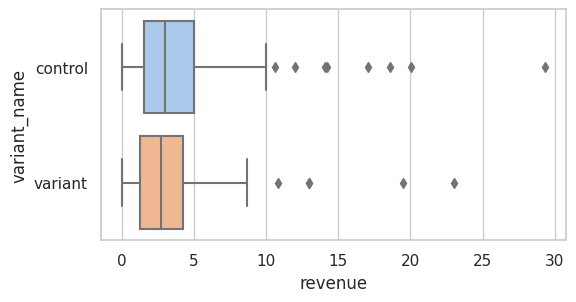

In [51]:
sns.boxplot(data = df_revenue, x = 'revenue', y = 'variant_name')

<Axes: xlabel='revenue', ylabel='Count'>

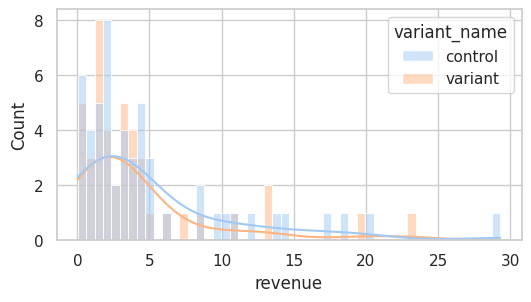

In [66]:
sns.set(rc={'figure.figsize':(6,3)}, style="whitegrid", palette="pastel")
sns.histplot(data=df_revenue, x='revenue', hue='variant_name', kde=True, bins=50)

#### CR / ARPU / ARPPU

In [53]:
t = df.groupby('variant_name').agg({'user_id':'nunique','revenue':'sum'})
t_paying_users = df_revenue.groupby('variant_name').agg({'user_id':'nunique'})
t = (t.merge(t_paying_users, on='variant_name', how='left')
      .rename(columns={'variant_name':'variant_name', 'user_id_x':'users', 'user_id_y':'paying_users', 'revenue':'revenue'}))
t['cr'] = t['paying_users'] / t['users']
t['arpu'] = t['revenue'] / t['users']
t['arppu'] = t['revenue'] / t['paying_users']
t

,users,revenue,paying_users,cr,arpu,arppu
variant_name,,,,,,
control,2389,274.550,53,0.022,0.115,5.180
variant,2393,179.320,42,0.018,0.075,4.270


## 🧪 Checking for the normality and A/B Testing

### All users

In [54]:
variant = df[df['variant_name'] == 'variant']['revenue']
control = df[df['variant_name'] == 'control']['revenue']
test_leven, p_value = stats.levene(variant, control)
alpha = 0.05
if p < alpha:
    print(f'\nP_value = {p_value}.\n\nGroups is different.  Reject the hypothesis of equality of variances.')
else:
    print(f'\nP_value = {p_value}.\n\nGroups is similar.  Accept the hypothesis of equality of variances.')


P_value = 0.17149090193725022.

Groups is similar.  Accept the hypothesis of equality of variances.


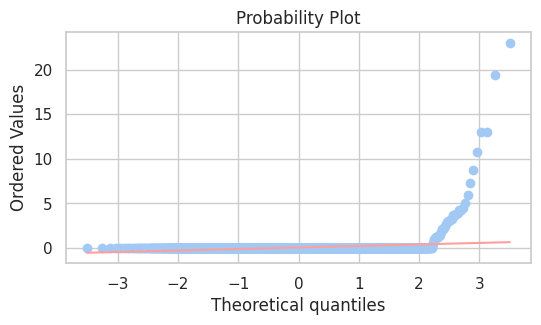


P_value = 0.0. 

It's not normal distribution




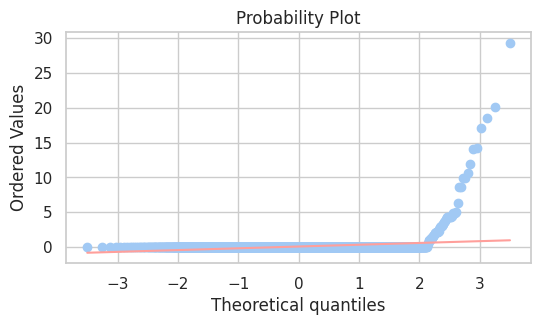


P_value = 0.0. 

It's not normal distribution




In [55]:
for group in [variant, control]:
    stats.probplot(group, dist="norm", plot=pylab)
    pylab.show()
    sns.set(rc={'figure.figsize':(6,3)}, style="whitegrid", palette="pastel")
    x = shapiro(group)
    if x.pvalue > 0.05:
        print(f"\nP_value = {x.pvalue}. \n\nIt's normal distribution\n\n")
    else:
        print(f"\nP_value = {x.pvalue}. \n\nIt's not normal distribution\n\n")


In [56]:
def ab_test(a, b): 
    alpha = 0.05 
    revenue_difference_mannwhitney = mannwhitneyu(variant, control)
    if revenue_difference_mannwhitney.pvalue < alpha:  
        print(f"\nP_value = {revenue_difference_mannwhitney.pvalue} \n\nGroups is different. Reject the hypothesis of equality of revenue.")
    else: 
        print(f"\nP_value = {revenue_difference_mannwhitney.pvalue}. \n\nGroups is similar. Accept the hypothesis of equality of revenue.")
ab_test(variant, control)        


P_value = 0.2859842308619548. 

Groups is similar. Accept the hypothesis of equality of revenue.


### Paying users

In [57]:
variant = df_revenue[df_revenue['variant_name'] == 'variant']['revenue']
control = df_revenue[df_revenue['variant_name'] == 'control']['revenue']
test_leven, p_value = stats.levene(variant, control)
alpha = 0.05
if p_value < alpha:
    print(f'P_value = {p_value.round(3)}. Groups is different.  Reject the hypothesis of equality of variances.')
else:
    print(f'P_value = {p_value.round(3)}. Groups is similar.  Accept the hypothesis of equality of variances.')

P_value = 0.399. Groups is similar.  Accept the hypothesis of equality of variances.


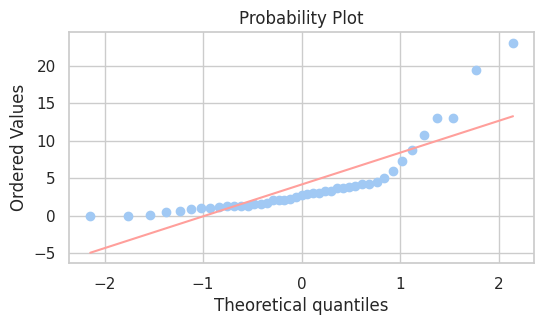


P_value = 5.565184935107936e-08.  

It's not normal distribution




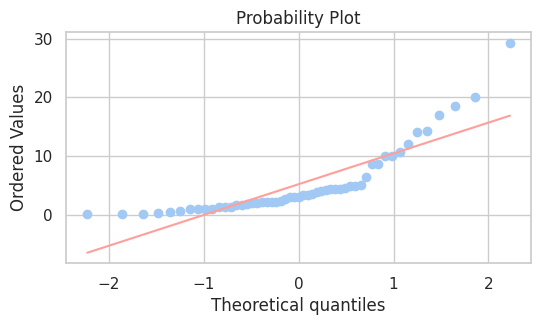


P_value = 4.1299607289602136e-08.  

It's not normal distribution




In [71]:
for group in [variant, control]:
    sns.set(rc={'figure.figsize':(6,3)}, style="whitegrid", palette="pastel")
    stats.probplot(group, dist="norm", plot=pylab)
    pylab.show()
    x = shapiro(group)
    if x.pvalue > 0.05:
        print(f"\nP_value = {x.pvalue}. \n\nIt's normal distribution\n\n")
    else:
        print(f"\nP_value = {x.pvalue}.  \n\nIt's not normal distribution\n\n")

In [59]:
def ab_test(a, b): 
    alpha = 0.05
    revenue_difference_mannwhitney = mannwhitneyu(variant, control)
    if revenue_difference_mannwhitney.pvalue < alpha: 
        print(f"\nP_value = {revenue_difference_mannwhitney.pvalue}. \n\nGroups is different. Reject the hypothesis of equality of revenue.")
    else:
        print(f"\nP_value = {revenue_difference_mannwhitney.pvalue}. \n\nGroups is similar. Accept the hypothesis of equality of revenue.")
ab_test(variant, control) 


P_value = 0.4218148352342157. 

Groups is similar. Accept the hypothesis of equality of revenue.


## 📚 Inferences

- The revenue of the control group, convertion rate, average revenue per user and average revenue per paying user is higher. 
- But ab-test shown that users in variant and control groups are similar. 